# RNN Implementation for Energy Forecasting

In this notebook, we will implement Recurrent Neural Networks (RNNs) using TensorFlow and Keras to forecast building energy consumption. We will compare three architectures:
1.  **Vanilla RNN**
2.  **Long Short-Term Memory (LSTM)**
3.  **Gated Recurrent Unit (GRU)**

We will use the `building_1298.csv` dataset.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## 1. Data Loading and Preprocessing

First, we load the dataset and select the target variable (energy consumption) and relevant features.

In [31]:
# Load data
df = pd.read_csv('data/building_1298.csv', index_col='datetime', parse_dates=True)
print(df.head())

# For this example, we will focus on predicting 'meter_reading' using past values.
# We can also include 'air_temperature' as an exogenous variable.
# Note: The column names in the CSV are 'm0', 'm1', etc. for meters. Let's assume 'm0' is the main meter.
data = df[['m0', 'air_temperature']].copy()

# Handle missing values
# Check for NaNs
print("Missing values before drop:")
print(data.isna().sum())

# Drop rows with NaNs to avoid 'nan' loss during training
data = data.dropna()

print("Missing values after drop:")
print(data.isna().sum())

data = data.values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

                          m0       m1       m2        m3  air_temperature  \
datetime                                                                    
2016-01-01 00:00:00  416.169  1994.63  2334.99    0.0000              5.6   
2016-01-01 01:00:00  408.616  2101.56  2755.43   79.5127              5.6   
2016-01-01 02:00:00  412.072  1885.37  2564.32    0.0000              5.6   
2016-01-01 03:00:00  393.053  1909.73  2804.94    0.0000              5.6   
2016-01-01 04:00:00  404.519  1882.42  2621.65  132.9570              5.0   

                     cloud_coverage  dew_temperature  precip_depth_1_hr  \
datetime                                                                  
2016-01-01 00:00:00             0.0             -0.6                0.0   
2016-01-01 01:00:00             0.0             -0.6                0.0   
2016-01-01 02:00:00             4.0             -0.6                0.0   
2016-01-01 03:00:00             NaN             -1.1                0.0   
2016-01-01

### Sequence Creation

RNNs require input data to be in the form of 3D arrays: `[samples, time steps, features]`.
We will create sequences of a fixed length (e.g., 24 hours) to predict the next value.

In [32]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0]) # Predict only m0
    return np.array(X), np.array(y)

SEQ_LENGTH = 24
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (7004, 24, 2), (7004,)
Test shape: (1752, 24, 2), (1752,)


## 2. Model Training

We will define a helper function to build and train models.

In [33]:
def build_and_train(model_type, X_train, y_train, epochs=20, batch_size=32):
    model = Sequential()
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'LSTM':
        model.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'GRU':
        model.add(GRU(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)
    return model, history

### Vanilla RNN

In [34]:
rnn_model, rnn_history = build_and_train('SimpleRNN', X_train, y_train)

c:\Users\Phiniqs\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0202 - val_loss: 0.0541
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - val_loss: 0.0222
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0175
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060 - val_loss: 0.0159
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - val_loss: 0.0151
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_loss: 0.0141
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054 - val_loss: 0.0130
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0122
Epoch 9/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0117
Epoch 10/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0052 - val_loss: 0.0115
Epoch 11/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0052 - val_loss: 0.0115
Epoch 12/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

### LSTM

In [35]:
lstm_model, lstm_history = build_and_train('LSTM', X_train, y_train)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0259 - val_loss: 0.0300
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - val_loss: 0.0269
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0067 - val_loss: 0.0220
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0058 - val_loss: 0.0160
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056 - val_loss: 0.0135
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0055 - val_loss: 0.0119
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0054 - val_loss: 0.0107
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053 - val_loss: 0.0098
Epoch 9/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052 - val_loss: 0.0092
Epoch 10/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052 - val_loss: 0.0087
Epoch 11/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051 - val_loss: 0.0084
Epoch 12/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/ste

### GRU

In [26]:
gru_model, gru_history = build_and_train('GRU', X_train, y_train)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0301 - val_loss: 0.0444
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0061 - val_loss: 0.0332
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0057 - val_loss: 0.0242
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0054 - val_loss: 0.0184
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0053 - val_loss: 0.0156
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0053 - val_loss: 0.0141
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - val_loss: 0.0132
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - val_loss: 0.0125
Epoch 9/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - val_loss: 0.0119
Epoch 10/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0051 - val_loss: 0.0113
Epoch 11/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0051 - val_loss: 0.0107
Epoch 12/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/ste

## 3. Evaluation and Comparison

Let's compare the training and validation loss curves and the predictions on the test set.

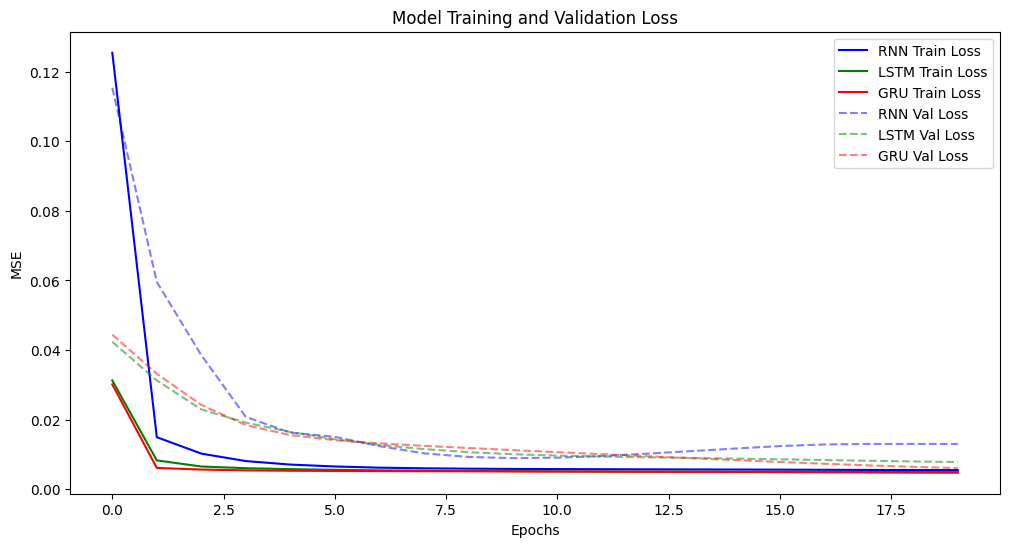

In [27]:
plt.figure(figsize=(12, 6))

# Plot Training Loss
plt.plot(rnn_history.history['loss'], label='RNN Train Loss', linestyle='-', color='blue')
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss', linestyle='-', color='green')
plt.plot(gru_history.history['loss'], label='GRU Train Loss', linestyle='-', color='red')

# Plot Validation Loss
plt.plot(rnn_history.history['val_loss'], label='RNN Val Loss', linestyle='--', color='blue', alpha=0.5)
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss', linestyle='--', color='green', alpha=0.5)
plt.plot(gru_history.history['val_loss'], label='GRU Val Loss', linestyle='--', color='red', alpha=0.5)

plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [28]:
# Make predictions
rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)
gru_pred = gru_model.predict(X_test)

# Inverse transform to get actual values
# We need to create a dummy array to inverse transform because scaler expects 2 features
def inverse_transform(pred, scaler):
    dummy = np.zeros((len(pred), 2))
    dummy[:, 0] = pred.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

y_test_actual = inverse_transform(y_test.reshape(-1, 1), scaler)
rnn_pred_actual = inverse_transform(rnn_pred, scaler)
lstm_pred_actual = inverse_transform(lstm_pred, scaler)
gru_pred_actual = inverse_transform(gru_pred, scaler)

print(f"RNN MSE: {mean_squared_error(y_test_actual, rnn_pred_actual):.2f}")
print(f"LSTM MSE: {mean_squared_error(y_test_actual, lstm_pred_actual):.2f}")
print(f"GRU MSE: {mean_squared_error(y_test_actual, gru_pred_actual):.2f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RNN MSE: 1569.56
LSTM MSE: 1698.88
GRU MSE: 1661.07


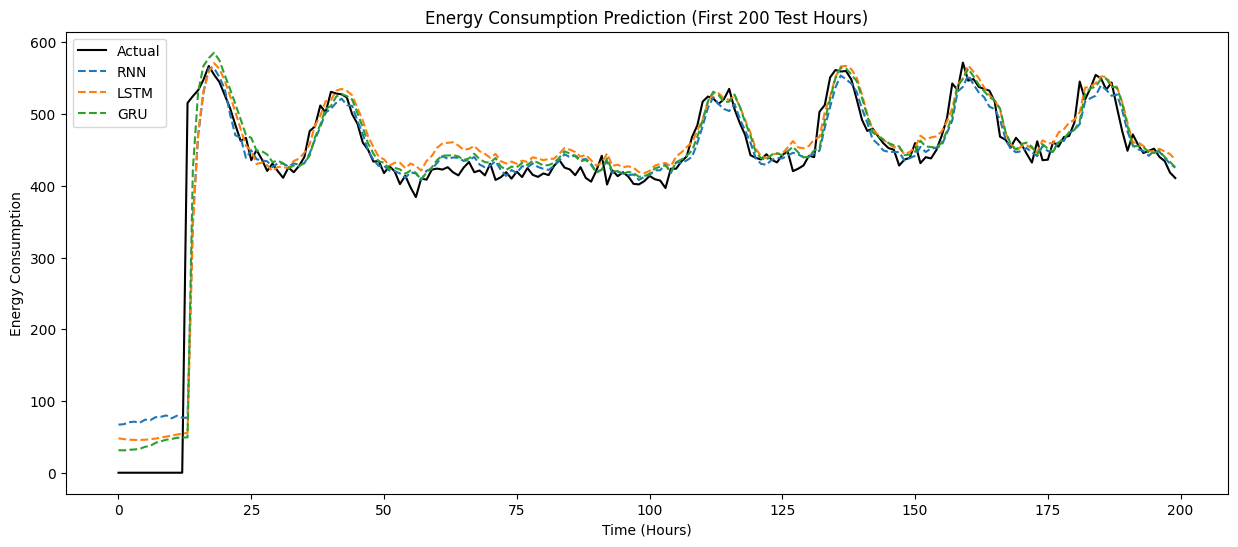

In [29]:
# Plot a subset of predictions
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[:200], label='Actual', color='black')
plt.plot(rnn_pred_actual[:200], label='RNN', linestyle='--')
plt.plot(lstm_pred_actual[:200], label='LSTM', linestyle='--')
plt.plot(gru_pred_actual[:200], label='GRU', linestyle='--')
plt.title('Energy Consumption Prediction (First 200 Test Hours)')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

## Conclusion

In this notebook, we implemented and compared Vanilla RNN, LSTM, and GRU models for building energy forecasting. 

Typically, LSTM and GRU models outperform Vanilla RNNs on longer sequences due to their ability to capture long-term dependencies and avoid the vanishing gradient problem. However, for shorter sequences or simpler patterns, the performance difference might be negligible.